In [49]:
import jax.numpy as jnp
from jax import jit,grad,hessian,jacfwd,jacrev
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from jax.scipy.linalg import block_diag
from jax.scipy.linalg import solve

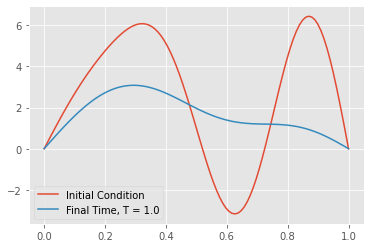

In [50]:
fourier_coefficients = jnp.array([3.,2.,3,-3.,1.])
frequencies = jnp.arange(1,len(fourier_coefficients)+1)* jnp.pi
kappa = 0.02
def f_single(x):
    return jnp.sum(fourier_coefficients * jnp.sin(frequencies * x))

f = jax.vmap(f_single)

def u_single(tx):
    t = tx[0]
    x = tx[1]
    new_coefficients = jnp.exp(-frequencies**2 * t * kappa) * fourier_coefficients
    return jnp.sum(new_coefficients * jnp.sin(frequencies * x))
u_true_function = jax.vmap(u_single)

gridsize = 100
grid = np.linspace(0,1,gridsize)
final_time = 1.
tx_input = jnp.vstack([jnp.ones(gridsize)*final_time,grid]).T

plt.plot(grid,f(grid),label = "Initial Condition")
plt.plot(grid,u_true_function(tx_input),label = f"Final Time, T = {final_time}")
plt.legend()
plt.show()

In [51]:
def build_tx_grid(t_range,x_range,num_grid_t,num_grid_x):
    full_t_grid = jnp.linspace(t_range[0],t_range[1],num_grid_t)
    full_x_grid = jnp.linspace(x_range[0],x_range[1],num_grid_x)
    x_interior = full_x_grid[1:-1]
    x_boundary = full_x_grid[jnp.array([0,-1])]

    #Get interior points
    t,x = jnp.meshgrid(full_t_grid,x_interior)
    tx_interior = jnp.vstack([t.flatten(),x.flatten()]).T

    #I'm doing this with meshgrid to handle more general higher dimensions, ie circular domain in 2d
    #Get boundary points
    t,x = jnp.meshgrid(full_t_grid,x_boundary)
    tx_boundary = jnp.vstack([t.flatten(),x.flatten()]).T
    return tx_interior,tx_boundary

In [56]:
num_grid_points = 26

tx_int,tx_bdy = build_tx_grid([0,1],[0,1],num_grid_points,num_grid_points)

tx_all = jnp.vstack([tx_bdy,tx_int])

init_obs_inds = jnp.where(tx_int[:,0]==0)[0][::1]
num_init_obs_inds = len(init_obs_inds)


u_true = u_true_function(tx_all)

num_obs = 35
np.random.seed(15)

remaining_inds = list(
    set(list(np.arange(len(tx_int)))) - 
    set(list(np.where(tx_int[:,0]==0)[0]))
)

x_t_sample_inds = np.random.choice(remaining_inds,num_obs-num_init_obs_inds,replace = False)
x_t_sample_inds = jnp.hstack([init_obs_inds,x_t_sample_inds])

tx_obs = jnp.vstack([tx_bdy,tx_int[x_t_sample_inds]])

u_obs = u_true_function(tx_obs)


In [57]:
# plt.tricontourf(tx_obs[:,0],tx_obs[:,1],u_obs)
# plt.scatter(tx_obs[:,0],tx_obs[:,1])
# plt.xlim(-0.1,1.1)
# plt.ylim(-0.1,1.1)

In [58]:
num_fine_grid = 100
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


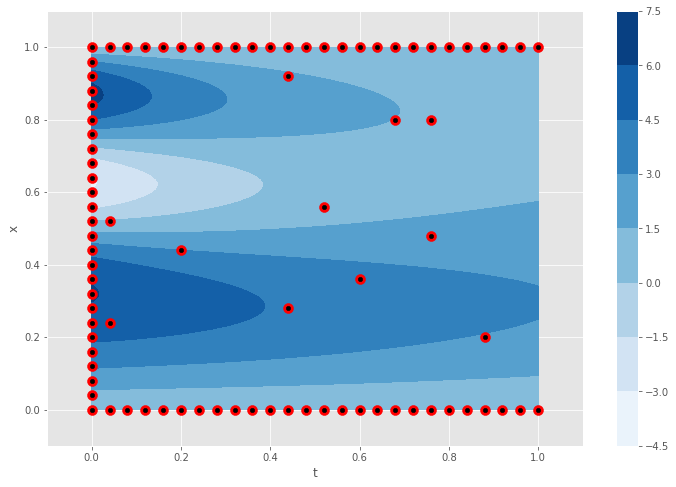

(-0.1, 1.1)

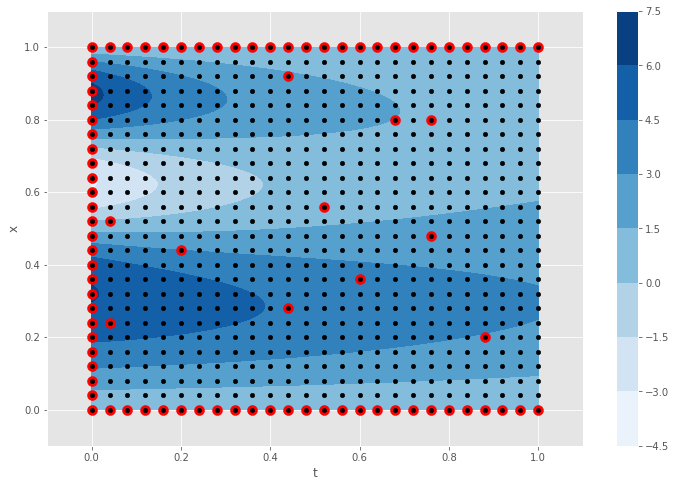

In [60]:
plt.figure(figsize=(12,8))

plt.tricontourf(tx_fine[:,0],tx_fine[:,1],u_true_function(tx_fine),cmap = 'Blues')
plt.colorbar()

plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red', s = 100)
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='black',s = 20)


plt.xlabel("t")
plt.ylabel("x")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.show()

plt.figure(figsize=(12,8))

plt.tricontourf(tx_fine[:,0],tx_fine[:,1],u_true_function(tx_fine),cmap = 'Blues')
plt.colorbar()

plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red', s = 100)
plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 20)


plt.xlabel("t")
plt.ylabel("x")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)


In [64]:
u_operators = [eval_k,dx_k,dt_k]
feature_operators = [eval_k,dx_k,dxx_k]


k_u = get_gaussianRBF(0.1)#get_sum_of_kernels([get_gaussianRBF(0.05),get_gaussianRBF(0.2)],coefficients=[0.5,0.5])#get_gaussianRBF(0.1)

u_model = InducedRKHS(
    tx_all,
    feature_operators,
    k_u
    )

u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,tx_int,u_params_init))
    .reshape(
            len(tx_int),
            len(feature_operators),
            order = 'F'
        )
)

k_P = get_centered_scaled_poly_kernel(2,grid_features_init,c=1)
class P_model():
    kernel_function = jit(
        get_kernel_block_ops(k_P,[eval_k],[eval_k])
    )

    @jit
    def predict(input_data,params):
        K = P_model.kernel_function(input_data,input_data)
        return K@params

class EqnModel():
    datafit_weight = 10

    @jit
    def get_grid_features(u_params):
        evaluation = u_model.evaluate_operators(feature_operators,tx_int,u_params)
        grid_features = evaluation.reshape(len(tx_int),len(feature_operators),order = 'F')
        return grid_features
    
    @jit
    def get_grid_target(u_params):
        return u_model.evaluate_operators([dt_k],tx_int,u_params)
    
    @jit
    def eval_obs_points(u_params):
        return u_model.point_evaluate(tx_obs,u_params)
    
    @jit
    def datafit_residual(u_params):
        obs_preds = EqnModel.eval_obs_points(u_params)
        return u_obs - obs_preds
    
    @jit
    def equation_residual(full_params):
        u_params = full_params[:u_model.num_params]
        P_params = full_params[u_model.num_params:]
        P_features = EqnModel.get_grid_features(u_params)
        P_model_preds = P_model.predict(P_features,P_params)
        ugrid_target = EqnModel.get_grid_target(u_params)
        return (ugrid_target - P_model_preds)
    
    @jit
    def F(full_params):
        u_params = full_params[:u_model.num_params]
        eqn_res = EqnModel.equation_residual(full_params)
        data_res = EqnModel.datafit_residual(u_params)
        return jnp.hstack([
            EqnModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
            eqn_res/jnp.sqrt(len(eqn_res))
            ])
    
    jac = jit(jacrev(F))

    def loss(full_params):
        return jnp.linalg.norm(EqnModel.F(full_params))**2
    
    @jit
    def damping_matrix(full_params):
        u_params = full_params[:u_model.num_params]
        grid_feats = EqnModel.get_grid_features(u_params)
        kmat_P = P_model.kernel_function(grid_feats,grid_feats)
        dmat = block_diag(
            u_model.kmat+1e-3 * diagpart(u_model.kmat),
            1e-3 * (kmat_P+1e-3 * jnp.identity(len(kmat_P)))
        )
        return dmat

In [65]:
import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize
params_init = jnp.hstack([u_params_init,jnp.zeros(len(tx_int))])

params,loss_vals,JtRes,improvement_ratios,alpha_vals,iterate_history = LevenbergMarquadtMinimize(
    params_init.copy(),
    EqnModel,
    beta = 1e-9,
    max_iter = 501,
    init_alpha=1,
    line_search_increase_ratio=3.
)

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 6.525, Jres = 535.1, alpha = 0.9091
Iteration 1, loss = 4.331, Jres = 850.4, alpha = 0.8264
Iteration 2, loss = 3.29, Jres = 214.0, alpha = 0.7513
Iteration 3, loss = 2.615, Jres = 130.5, alpha = 0.683
Iteration 4, loss = 2.146, Jres = 73.04, alpha = 0.6209
Iteration 5, loss = 1.797, Jres = 61.89, alpha = 0.5645
Iteration 50, loss = 0.03288, Jres = 1.883, alpha = 0.007744
Iteration 100, loss = 0.001665, Jres = 2.3, alpha = 6.597e-05
Iteration 150, loss = 0.000811, Jres = 0.008006, alpha = 0.0001494
Iteration 200, loss = 0.000694, Jres = 0.006657, alpha = 0.0001494
Iteration 250, loss = 0.0006172, Jres = 0.0006768, alpha = 0.0001494
Iteration 300, loss = 0.0005576, Jres = 0.0006192, alpha = 0.0001494
Iteration 350, loss = 0.0005091, Jres = 0.000386, alpha = 0.0001494
Iteration 400, loss = 0.0004686, Jres = 0.0003509, alpha = 0.0001494
Iteration 450, loss = 0.0004343, Jres = 0.0004216, alpha = 0.0001494
Line Search Failed!
Final Iteration Results
Iteration 475, loss =

In [66]:
hess_loss = jit(jax.hessian(EqnModel.loss))
gradloss = jit(jax.grad(EqnModel.loss))

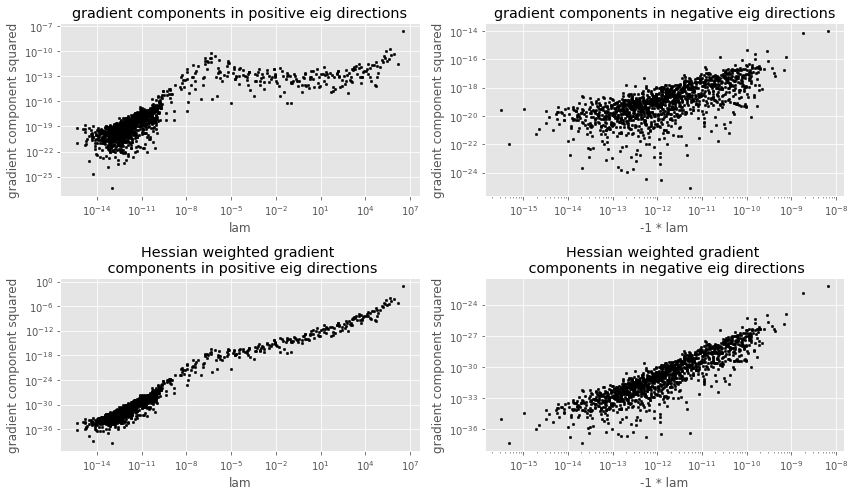

Most negative eigenvalue  -6.609047369427136e-09


In [67]:
H = hess_loss(params)
g = gradloss(params)

analyze_hessian(H,g)

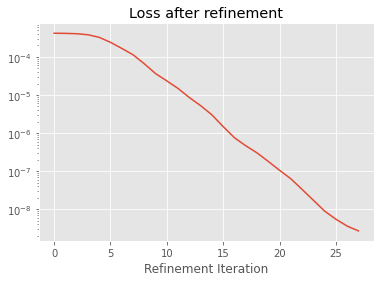

In [68]:
from LM_Solve import refine_solution

p_adjusted,refinement_losses = refine_solution(params,EqnModel)

plt.plot(refinement_losses)
plt.xlabel("Refinement Iteration")
plt.title("Loss after refinement")
plt.yscale('log')

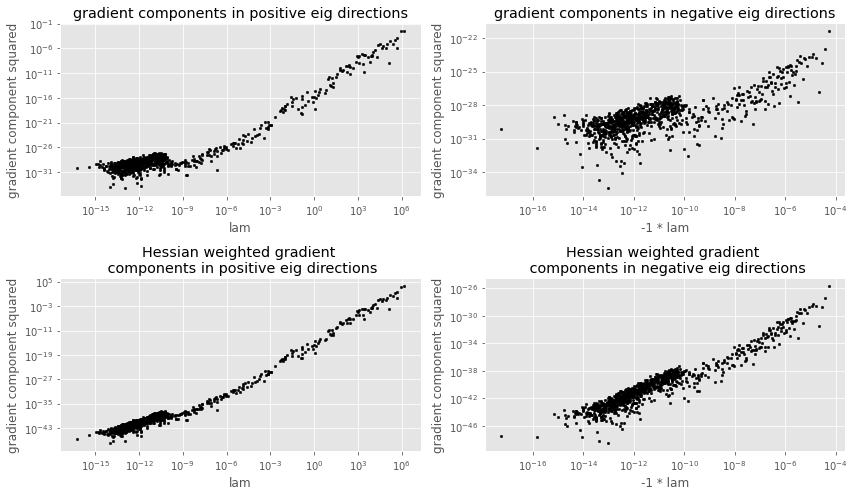

Most negative eigenvalue  -5.273761632129684e-05


In [14]:
analyze_hessian(hess_loss(p_adjusted),gradloss(p_adjusted))

In [69]:
# u_sol = params[:u_model.num_params]
# P_sol = params[u_model.num_params:]

u_sol = p_adjusted[:u_model.num_params]
P_sol = p_adjusted[u_model.num_params:]

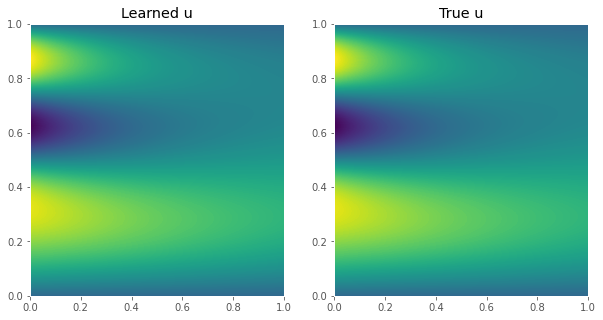

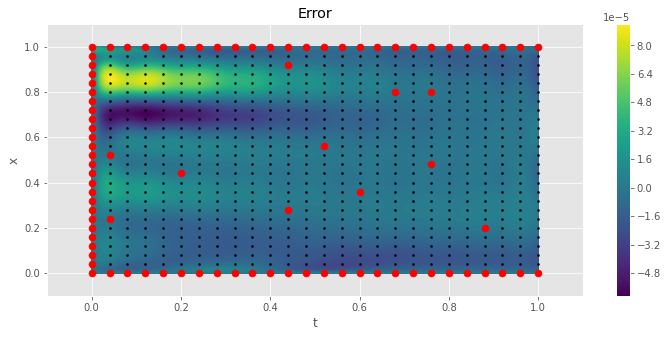

In [70]:
num_fine_grid = 100
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


u_eval_fine =u_model.point_evaluate(tx_grid_fine,u_sol)

u_true_fine = u_true_function(tx_grid_fine)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Learned u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_eval_fine,200)
plt.subplot(1,2,2)
plt.title("True u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_true_fine,200)
plt.show()
plt.figure(figsize = (12,5))
plt.title("Error")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_true_fine-u_eval_fine,250)
plt.colorbar()
plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 4)
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red',s = 50)

plt.xlabel("t")
plt.ylabel("x")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.show()

In [71]:
num_fine_grid = 100
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
tx_fine_int = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


grad_u_true = jax.vmap(grad(u_single))(tx_fine_int)
hess_u_true = jax.vmap(hessian(u_single))(tx_fine_int)

u_true_interior = u_true_function(tx_fine_int)
ut_true = grad_u_true[:,0]
ux_true = grad_u_true[:,1]
uxx_true = hess_u_true[:,1,1]

true_features = jnp.vstack([u_true_interior,ux_true,uxx_true]).T
model_grid_features = EqnModel.get_grid_features(u_sol)
model_features = u_model.evaluate_operators(feature_operators,tx_fine_int,u_sol).reshape(len(tx_fine_int),len(feature_operators),order = 'F')

preds_ut_model_features = P_model.kernel_function(model_features,model_grid_features)@P_sol
preds_ut_true_features = P_model.kernel_function(true_features,model_grid_features)@P_sol

init_P_features = EqnModel.get_grid_features(u_params_init)

K = P_model.kernel_function(init_P_features,init_P_features)

P_params_naive = solve(K+1e-5*diagpart(K),EqnModel.get_grid_target(u_params_init))

init_P_features_fine = u_model.evaluate_operators(feature_operators,tx_fine_int,u_params_init).reshape(len(tx_fine_int),len(feature_operators),order = 'F')
P_preds_init_model_features_init = P_model.kernel_function(init_P_features_fine,init_P_features)@P_params_naive

P_preds_init_model_features = P_model.kernel_function(model_features,init_P_features)@P_params_naive
P_preds_init_true_features = P_model.kernel_function(true_features,init_P_features)@P_params_naive

In [72]:
def get_nrmse(true,pred):
    return jnp.mean((true-pred)**2)/jnp.mean(true**2)

print("Optimized model feature predictions ",get_nrmse(ut_true,preds_ut_model_features))
print("Optimized true feature predictions ",get_nrmse(ut_true,preds_ut_true_features))
print("Naive model feature predictions ",get_nrmse(ut_true,P_preds_init_model_features))
print("Naive true feature predictions ",get_nrmse(ut_true,P_preds_init_true_features))
print("Naive init model feature predictions ",get_nrmse(ut_true,P_preds_init_model_features_init))

Optimized model feature predictions  1.2547293270746669e-09
Optimized true feature predictions  1.7469042895500616e-09
Naive model feature predictions  0.4358641056111655
Naive true feature predictions  0.43586891546746953
Naive init model feature predictions  0.5765520586428612


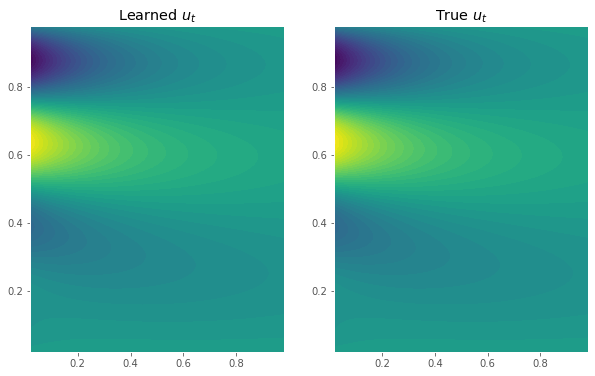

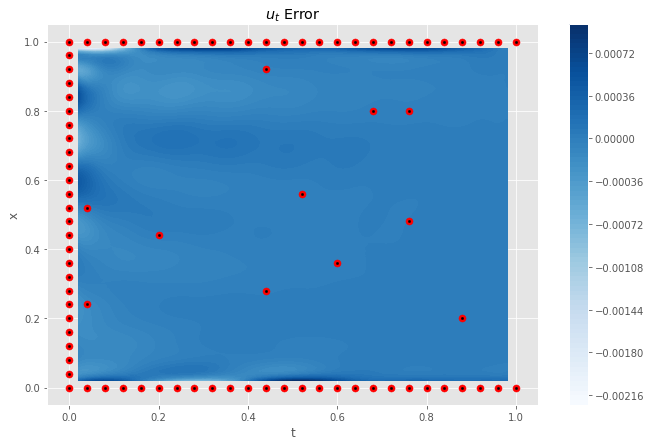

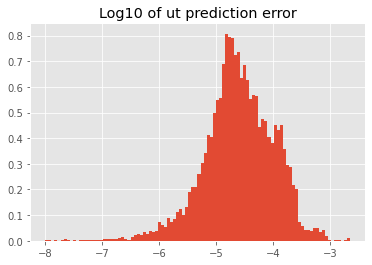

In [85]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.title("Learned $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],preds_ut_model_features,50,)
plt.subplot(1,2,2)
plt.title("True $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true,50)
plt.show()
plt.figure(figsize=(11,7))
plt.title("$u_t$ Error")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true-preds_ut_model_features,100,cmap = 'Blues')
plt.colorbar()
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red',s = 50,label = 'Given value of u(t,x)')
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='black',s = 5,label = 'Given value of u(t,x)')

#plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 4)
plt.xlabel("t")
plt.ylabel("x")
plt.show()
plt.title("Log10 of ut prediction error")
plt.hist(jnp.log10(jnp.abs(ut_true-preds_ut_model_features) + 1e-20),100,density = True)
plt.show()